In [15]:
import dgl
from dgl.data import DGLDataset
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv,MaxPooling
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import os
import pandas
import networkx as nx
%matplotlib inline

In [2]:
class CIFAR10TrainDataset(DGLDataset):
    def __init__(self,data_path):
        self.data_path = data_path
        super().__init__(name='cifar10_train__gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)


class CIFAR10TestDataset(DGLDataset):
    def __init__(self,data_path):
        self.data_path = data_path
        super().__init__(name='cifar10_test_gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)

In [3]:
traindataset = CIFAR10TrainDataset("../data/NewMyData/train_dist_40_full.dgl")
testdataset = CIFAR10TestDataset("../data/NewMyData/test_dist_40_full.dgl")

In [4]:
def return_two_list(node_num):
    taikaku = torch.full((node_num,node_num),fill_value=1.)
    for i in range(node_num):
        taikaku[i][i] = 0.
    src_ids = []
    dst_ids = []
    for i in range(node_num):
        for j in range(i,node_num):
            if taikaku[i][j] != 0:
                src_ids.append(i)
                dst_ids.append(j)
                src_ids.append(j)
                dst_ids.append(i)
    tensor_src = torch.tensor(src_ids)
    tensor_dst = torch.tensor(dst_ids)
    return tensor_src,tensor_dst

In [5]:
num_node_list = [5,10,15,20,25,30,35]
#num_node_list = [5]
graphs = []
labels = []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
for node_num in num_node_list:
    print(f'node : {node_num}')
    src,dst = return_two_list(node_num)
    graphs = []
    labels = []
    for graph,label in tqdm(traindataset):
        graph = graph.to(device)
        pool_graph = torch.zeros((node_num,node_num),device=device)
        for p in range(node_num):
            pool_graph[p] = graph.ndata['feat value'][-node_num + p][-node_num:]
        g = dgl.graph((src,dst),num_nodes=node_num,device=device)
        g.ndata['feat value'] = pool_graph
        graphs.append(g)
        labels.append(label)
    output_labels = {'label':torch.tensor(labels)}
    path = f'../data/somedata/train_dist_{node_num}_full.dgl'
    dgl.save_graphs(path,g_list=graphs,labels=output_labels)

        
for node_num in num_node_list:
    print(f'node : {node_num}')
    src,dst = return_two_list(node_num)
    graphs = []
    labels = []
    for graph,label in tqdm(testdataset):
        graph = graph.to(device)
        pool_graph = torch.zeros((node_num,node_num),device=device)
        for p in range(node_num):
            pool_graph[p] = graph.ndata['feat value'][-node_num + p][-node_num:]
        g = dgl.graph((src,dst),num_nodes=node_num,device=device)
        g.ndata['feat value'] = pool_graph
        graphs.append(g)
        labels.append(label)
    output_labels = {'label':torch.tensor(labels)}
    path = f'../data/somedata/test_dist_{node_num}_full.dgl'
    dgl.save_graphs(path,g_list=graphs,labels=output_labels)


node : 5


100%|██████████| 50000/50000 [00:30<00:00, 1630.33it/s]


node : 10


100%|██████████| 50000/50000 [00:34<00:00, 1458.27it/s]


node : 15


100%|██████████| 50000/50000 [00:38<00:00, 1288.01it/s]


node : 20


100%|██████████| 50000/50000 [00:42<00:00, 1183.85it/s]


node : 25


100%|██████████| 50000/50000 [00:44<00:00, 1123.60it/s]


node : 30


100%|██████████| 50000/50000 [00:47<00:00, 1045.22it/s]


node : 35


100%|██████████| 50000/50000 [00:49<00:00, 1004.46it/s]


node : 5


100%|██████████| 10000/10000 [00:06<00:00, 1574.65it/s]


node : 10


100%|██████████| 10000/10000 [00:05<00:00, 1677.26it/s]


node : 15


100%|██████████| 10000/10000 [00:07<00:00, 1390.34it/s]


node : 20


100%|██████████| 10000/10000 [00:07<00:00, 1309.01it/s]


node : 25


100%|██████████| 10000/10000 [00:09<00:00, 1096.37it/s]


node : 30


100%|██████████| 10000/10000 [00:09<00:00, 1072.10it/s]


node : 35


100%|██████████| 10000/10000 [00:10<00:00, 958.96it/s]


### 画像を複数枚に分割し各パッチをノードとし、最近傍ノードと接続するグラフを作成

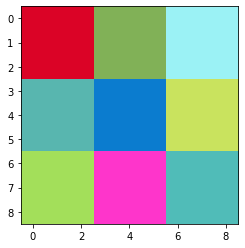

In [2]:
#テスト。6x6のカラー画像を作成。ただし2x2ごとに単一のカラーに設定。ランダムで。
images = np.random.randint(0,255,(9,9,3))
for i in range(0,9,3):
    for j in range(0,9,3):
        images[i:i+3,j:j+3,:] = np.random.randint(0,255,3,np.uint8)
plt.imshow(images)
plt.show()

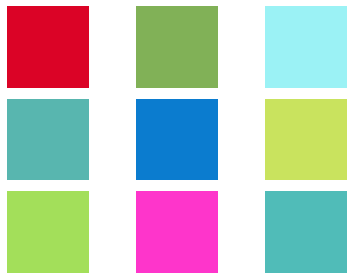

In [4]:
#画像をn分割。テストで3枚に分割。
num_patch=3
patch_width=int(9/3)
data=[]

for i in range(0,9,patch_width):
    for j in range(0,9,patch_width):
        data.append(images[i: i + num_patch,j: j + num_patch, :])

#分割した各パッチを正方形に表示
# 1枚の図を作成
fig = plt.figure()

# 画像を追加
for i in range(9):
    ax = fig.add_subplot(patch_width, patch_width, i+1)
    ax.imshow(data[i])
    ax.axis('off')

# 画像を表示
plt.tight_layout()
plt.show()

In [42]:
# 正方形の一辺の長さ
side_length = 3

# 0から8までの整数値を持つ正方形のリストを作成
square_list = np.arange(side_length**2).reshape((side_length, side_length))

print(square_list)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


In [14]:
x=0
y=0
# 再近傍のサイズ（周囲の画素の数）
neighborhood_size = 1

# 再近傍の画素を取得
neighborhood = square_list[max(0, y - neighborhood_size):min(square_list.shape[0], y + neighborhood_size + 1),
                           max(0, x - neighborhood_size):min(square_list.shape[1], x + neighborhood_size + 1)]

print(neighborhood)

[[0 1]
 [5 6]]


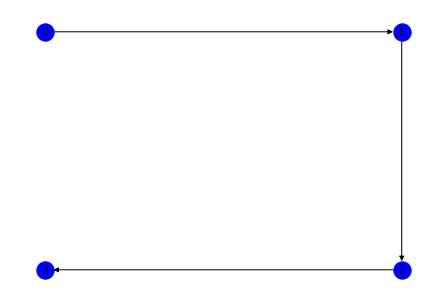

In [25]:
graph=dgl.DGLGraph()
graph.add_nodes(4)
graph.add_edges([0, 1, 2], [1, 2, 3])

nx_graph=graph.to_networkx()
pos = {0: (0, 1), 1: (1, 1), 2: (1, 0), 3: (0, 0)}
#pos=nx.spring_layout(nx_graph)
nx.draw(nx_graph,pos,with_labels=True,node_color='blue')
plt.show()

In [30]:
arr=np.random.randint(0,9,(3,3))
indices=np.ndindex(arr.shape)
all_indices=[idx for idx in indices]
rot90_indices=np.array(all_indices).reshape((3,3,2))
print(arr)
print(all_indices)
print(rot90_indices)

[[7 4 0]
 [2 0 8]
 [0 1 6]]
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
[[[0 0]
  [0 1]
  [0 2]]

 [[1 0]
  [1 1]
  [1 2]]

 [[2 0]
  [2 1]
  [2 2]]]


[[0 2]
 [1 2]
 [2 2]
 [0 1]
 [1 1]
 [2 1]
 [0 0]
 [1 0]
 [2 0]]
{0: array([0, 2]), 1: array([1, 2]), 2: array([2, 2]), 3: array([0, 1]), 4: array([1, 1]), 5: array([2, 1]), 6: array([0, 0]), 7: array([1, 0]), 8: array([2, 0])}
0 0
[0 1 3 4]
0 1
[0 1 3 4 6 7]
0 2
[3 4 6 7]
1 0
[0 1 2 3 4 5]
1 1
[0 1 2 3 4 5 6 7 8]
1 2
[3 4 5 6 7 8]
2 0
[1 2 4 5]
2 1
[1 2 4 5 7 8]
2 2
[4 5 7 8]


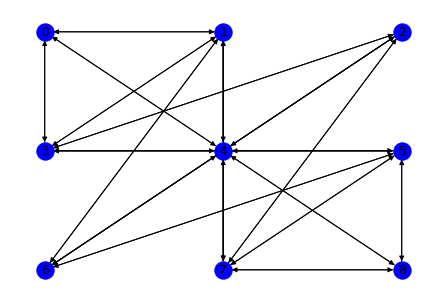

In [45]:
def get_rot90_index(arr):
    indices=np.ndindex(arr.shape)#インデックス計算
    all_indices=[idx for idx in indices]#リストに変換
    rot90=np.array(all_indices).reshape((3,3,2))#3,3,2に変形
    rot90=np.rot90(rot90,k=1)#90度回転
    rot90_flatt=rot90.reshape(9,2)#フラットに変換
    return rot90_flatt

#ノード数９のグラフを作成
g=dgl.DGLGraph()
g.add_nodes(9)

#3x3のリストのインデックスを取得し90回転させたリストを取得
rand_array=np.zeros((3,3))
rot90=get_rot90_index(rand_array)
print(rot90)
pos={}
for i in range(9):
    pos[i]=rot90[i]
print(pos)

# 正方形の一辺の長さ
side_length = 3
# 0から8までの整数値を持つ正方形のリストを作成
square_list = np.arange(side_length**2).reshape((side_length, side_length))

#ノード番号に対応したインデックスを取得
inds=np.ndindex(square_list.shape)
inds=[idx for idx in inds]
#各ノードと最近傍ノード間にエッジを張る
for i in range(9):
    x,y=inds[i]
    print(x,y)
    # 再近傍のサイズ（周囲の画素の数）
    neighborhood_size = 1
    # 再近傍のノード番号を取得
    neighborhood = square_list[max(0, y - neighborhood_size):min(square_list.shape[0], y + neighborhood_size + 1),
                            max(0, x - neighborhood_size):min(square_list.shape[1], x + neighborhood_size + 1)]
    #ノード番号をフラットに変形
    flatt_nh=np.array(neighborhood).flatten()
    print(flatt_nh)
    for j in flatt_nh:
        if i == j:
            continue
        else:
            g.add_edge(j,i)
nx_g=g.to_networkx()
nx.draw(nx_g,pos,with_labels=True,node_color='blue')
plt.show()

tensor([[0.1000],
        [0.2000],
        [0.3000]])


/home/makoto/anaconda3/envs/GDW/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'
